# Recherche du meilleur modèle XGBoost sur 2 classes

### Imports

In [1]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

## Import des scripts python
import sys
import os
sys.path.append(os.path.abspath('../../python_scripts/'))

#import load_datas
import train_model as train
import save_model as saveModel
#import pickle_model

# Rechargement en cas de modification
import importlib
importlib.reload(train)
importlib.reload(saveModel)
#importlib.reload(pickle_model)

<module 'save_model' from '/Users/thierno/Documents/DataScientest/Final_Project/MAR24_CDS_Accidents/Notebooks/Entrainements/python_scripts/save_model.py'>

### Chargement des datasets

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

pd.set_option('display.max_columns', None)

#df = pd.read_csv("../../data/accidents_data.zip", compression=dict(method='zip', archive_name='accidents_data.csv'))

#display(df.head())

#X = df.drop(columns=['grav'])
#y = df['grav']


X_train = pd.read_csv("../../../../Data/X_train.zip", compression=dict(method='zip', archive_name='X_train.csv'))
y_train = pd.read_csv("../../../../Data/y_train.zip", compression=dict(method='zip', archive_name='y_train.csv'))['grav']

X_test = pd.read_csv("../../../../Data/X_test.zip", compression=dict(method='zip', archive_name='X_test.csv'))
y_test = pd.read_csv("../../../../Data/y_test.zip", compression=dict(method='zip', archive_name='y_test.csv'))['grav']

print("X_train shape :",X_train.shape)
print("X_test shape :",X_test.shape)

y_train=y_train.replace({1:0})
y_train=y_train.replace({2:1,3:1})

y_test=y_test.replace({1:0})
y_test=y_test.replace({2:1,3:1})


X_train shape : (352893, 337)
X_test shape : (88224, 337)


### Rééquilibrage du dataset d'entrainement

In [3]:
from imblearn.under_sampling import RandomUnderSampler

ro = RandomUnderSampler(random_state=1024)
X_train_ru, y_train_ru = ro.fit_resample(X_train,y_train)

### XGBClassifier : modèle par défaut 

Temps d'entraînement : 1.34 seconds
Classification_Report: XGBClassifier_Default


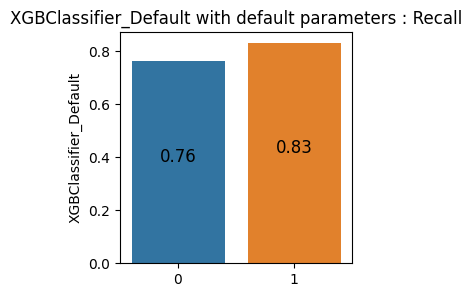

,0,1,Training_Time,Best_Params
XGBClassifier_Default,0.762667,0.830505,1.343529,Default


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
                               0         1  Training_Time Best_Params
 XGBClassifier_Default  0.762667  0.830505       1.343529     Default)

In [4]:
from xgboost import XGBClassifier

train.fit("XGBClassifier_Default",
          XGBClassifier(random_state=42),
          X_train_ru,
          y_train_ru,
          X_test,
          y_test)



### XGBClassifier : Grid Search

/Users/thierno/Documents/DataScientest/Final_Project/MAR24_CDS_Accidents/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Temps d'entraînement : 4.59 minutes
Classification_Report: XGBClassifier_Grid


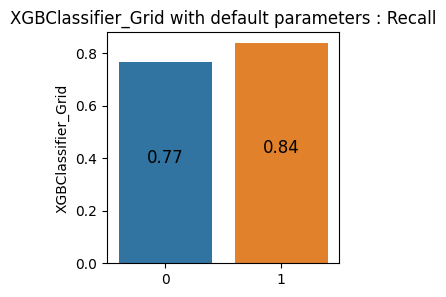

*** Best Param : {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300} ***


,0,1,Training_Time,Best_Params
XGBClassifier_Grid,0.765676,0.837682,275.269309,"{'learning_rate': 0.1, 'max_depth': 8, 'n_esti..."


In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from xgboost import XGBClassifier

param_grid = {
    # max_depth est la profondeur maximale de chaque arbre. Une valeur plus élevée rendra le modèle plus complexe et pourrait entraîner un surapprentissage.
    'max_depth': [3, 4, 5,7,8],
    
    # learning_rate (ou taux d'apprentissage) est le pas d'ajustement effectué à chaque étape de l'optimisation. Une valeur plus faible rendra l'apprentissage plus lent.
    'learning_rate': [0.01, 0.1, 0.2],
    
    # n_estimators est le nombre d'arbres à construire.
    'n_estimators': [100, 200, 300],
    
    
}

best_model, df_result = train.fit_grid_search("XGBClassifier_Grid",
                               XGBClassifier(random_state=42),
                               param_grid,
                               5,
                               X_train_ru,
                               y_train_ru,
                               X_test,
                               y_test)



### Sauvegarde du meilleur modèle 

In [6]:
import joblib

file_name = "best_models/xgboost_2_classes.gz"
saveModel.save(best_model, file_name)



### Test du chargement du modèle sauvegardé

In [7]:
from sklearn.metrics import classification_report

# Chargement du modele
#model = joblib.load(model_filename_gz)
model = saveModel.load(file_name)
# Prediction du model
y_pred = model.predict(X_test)

# Évaluation du modèle
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.77      0.85     71781
           1       0.45      0.84      0.59     16443

    accuracy                           0.78     88224
   macro avg       0.70      0.80      0.72     88224
weighted avg       0.86      0.78      0.80     88224

